Based on xscore for each team during a game, what was % of winning v losing

In [89]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import numpy as np
from expected_score_model.visualisation.afl_colours import team_colours


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [308]:
import matplotlib.font_manager as fm
import os
from expected_score_model.fonts.fonts import load_fonts
font_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/src/expected_score_model/fonts"
load_fonts(font_path)

In [2]:
from AFLPy.AFLData_Client import load_data, upload_data, metadata

Data

In [10]:
md = metadata()

In [5]:
match_score = load_data(Dataset_Name='AFL_API_Matches', ID = ["AFL_2021", "AFL_2022", "AFL_2023", "AFL_2024", "AFL_2025"])
match_score = match_score[match_score['Match_Status'] == 'CONCLUDED']

In [6]:
match_score['goal_Home'] = match_score.apply(lambda score: score['Q4_Score'].split('-')[0].split(".")[0], axis=1).astype(int)
match_score['behind_Home'] = match_score.apply(lambda score: score['Q4_Score'].split('-')[0].split(".")[1], axis=1).astype(int)
match_score['score_Home'] = match_score.apply(lambda score: score['Q4_Score'].split('-')[0].split(".")[2], axis=1).astype(int)
match_score['goal_Away'] = match_score.apply(lambda score: score['Q4_Score'].split('-')[1].split(".")[0], axis=1).astype(int)
match_score['behind_Away'] = match_score.apply(lambda score: score['Q4_Score'].split('-')[1].split(".")[1], axis=1).astype(int)
match_score['score_Away'] = match_score.apply(lambda score: score['Q4_Score'].split('-')[1].split(".")[2], axis=1).astype(int)

In [7]:
match_score = match_score.set_index('Match_ID')

In [8]:
match_score.head()

,CD_Match_ID,Home_Team,Away_Team,Venue,Date,Match_Status,Q4_Score,goal_Home,behind_Home,score_Home,goal_Away,behind_Away,score_Away
Match_ID,,,,,,,,,,,,,
AFL_2025_22_PortAdelaide_Fremantle,CD_M20250142201,Port Adelaide,Fremantle,Adelaide Oval,2025-08-09 10:10:00,CONCLUDED,13.8.86 - 13.14.92,13,8,86,13,14,92
AFL_2025_22_Carlton_GoldCoast,CD_M20250142204,Carlton,Gold Coast,Docklands,2025-08-09 09:35:00,CONCLUDED,11.8.74 - 13.15.93,11,8,74,13,15,93
AFL_2025_22_Brisbane_Sydney,CD_M20250142209,Brisbane,Sydney,Gabba,2025-08-09 06:15:00,CONCLUDED,13.12.90 - 13.14.92,13,12,90,13,14,92
AFL_2025_22_Richmond_StKilda,CD_M20250142205,Richmond,St Kilda,MCG,2025-08-09 03:20:00,CONCLUDED,7.10.52 - 8.8.56,7,10,52,8,8,56
AFL_2025_22_Geelong_Essendon,CD_M20250142202,Geelong,Essendon,Kardinia Park,2025-08-08 09:40:00,CONCLUDED,15.19.109 - 10.5.65,15,19,109,10,5,65


In [ ]:
shots = load_data(Dataset_Name = "CG_Expected_Score", ID = "AFL")
shots['Year'] = shots['Match_ID'].apply(lambda x: int(x.split("_")[1]))
shots['Round'] = shots['Match_ID'].apply(lambda x: x.split("_")[2])
shots['Home'] = np.where(shots['Team'] == shots['Home_Team'], 'Home', 'Away')
shots['goal'] = np.where(shots['Final_State'] == "goal", 1, 0)
shots['behind'] = np.where(shots['Final_State'] == "behind", 1, 0)
shots['score'] = shots['goal'] * 6 + shots['behind']


In [13]:
shots['goal'] = np.where(shots['Final_State'] == "goal", 1, 0)
shots['behind'] = np.where(shots['Final_State'] == "behind", 1, 0)
shots['score'] = shots['goal'] * 6 + shots['behind']

In [14]:
shots['Shot_At_Goal'].dtype

dtype('bool')

Match

In [19]:
match_id = 'AFL_2024_F2_GreaterWesternSydney_Brisbane'


In [20]:
match_shots = shots[shots['Match_ID'] == match_id]

In [21]:
def create_match_summary(shots):
    
    shots_home_away_summary = shots.groupby(['Match_ID', 'Team', 'Home', 'Year']).agg(
        score=('score', 'sum'),
        xscore=('xscore', 'sum'),
        num_shots=('score', 'size'),
        num_games=('Match_ID', 'nunique')
    )
    shots_home_away_summary = shots_home_away_summary.reset_index(drop=False).pivot(index = ['Match_ID', 'Year'], columns = ['Home'])
    shots_home_away_summary.columns = [f"{col[0]}_{col[1]}" for col in shots_home_away_summary.columns]
    
    return shots_home_away_summary
    

In [40]:
match_summary = create_match_summary(shots[shots['Year'] == 2024])
match_summary.head()

,,Team_Away,Team_Home,score_Away,score_Home,xscore_Away,xscore_Home,num_shots_Away,num_shots_Home,num_games_Away,num_games_Home
Match_ID,Year,,,,,,,,,,
AFL_2024_00_Brisbane_Carlton,2024,Carlton,Brisbane,82,70,66.146507,74.542017,20,23,1,1
AFL_2024_00_GoldCoast_Richmond,2024,Richmond,Gold Coast,53,87,42.517205,92.609422,14,28,1,1
AFL_2024_00_GreaterWesternSydney_Collingwood,2024,Collingwood,Greater Western Sydney,78,111,83.685565,70.661569,29,23,1,1
AFL_2024_00_Sydney_Melbourne,2024,Melbourne,Sydney,62,82,61.189188,80.948890,19,28,1,1
AFL_2024_01_Carlton_Richmond,2024,Richmond,Carlton,65,71,70.160129,79.967402,19,27,1,1


Simulate Match

In [41]:
match_stats = match_summary.loc[match_id]
match_stats

,Team_Away,Team_Home,score_Away,score_Home,xscore_Away,xscore_Home,num_shots_Away,num_shots_Home,num_games_Away,num_games_Home
Year,,,,,,,,,,
2024,Brisbane,Greater Western Sydney,100,98,97.14448,99.124338,29,29,1,1


In [42]:
match_summary.loc[match_id]['xscore_Home'].values[0]

99.12433761946768

In [43]:
import numpy as np

score_team_1 = match_score.loc[match_id]['score_Home']
score_team_2 = match_score.loc[match_id]['score_Away'] 

# Step 1: Define the mean values and standard deviations for the two teams
mean_team_1 = match_summary.loc[match_id]['xscore_Home'].values[0]  # Example mean for Team 1
mean_team_2 = match_summary.loc[match_id]['xscore_Away'].values[0]  # Example mean for Team 2
std_dev_team1 = match_summary['xscore_Home'].std()       # Assuming the same standard deviation for simplicity
std_dev_team2 = match_summary['xscore_Away'].std()       # Assuming the same standard deviation for simplicity

# Step 2: Set up the number of simulations
num_simulations = 100000

# Step 3: Simulate performance for each team
team_1_scores = np.random.normal(mean_team_1, std_dev_team1, num_simulations)
team_2_scores = np.random.normal(mean_team_2, std_dev_team2, num_simulations)

# Step 4: Determine outcomes
team_1_wins = np.sum(team_1_scores > team_2_scores)
team_2_wins = np.sum(team_1_scores < team_2_scores)
draws = num_simulations - (team_1_wins + team_2_wins)

# Step 5: Calculate probabilities
team_1_win_prob = team_1_wins / num_simulations
team_2_win_prob = team_2_wins / num_simulations
draw_prob = draws / num_simulations

# Display results
print(f"Team 1 win probability: {team_1_win_prob:.2%}")
print(f"Team 2 win probability: {team_2_win_prob:.2%}")
print(f"Draw probability: {draw_prob:.2%}")
print(f"score: Team 1 {score_team_1} - {score_team_2} Team 2")
print(f"xscore: Team 1 {mean_team_1:.4} - {mean_team_2:.4} Team 2")

Team 1 win probability: 52.78%
Team 2 win probability: 47.22%
Draw probability: 0.00%
score: Team 1 100 - 105 Team 2
xscore: Team 1 99.12 - 97.14 Team 2


Simulation from each shot

In [52]:
def simulate_match_from_shots(match_id, shots):
    # Filter shots for the given match
    match_shots = shots[shots['Match_ID'] == match_id]
    
    # Simulate each shot
    simulated_scores = []
    for _, shot in match_shots.iterrows():
        random_value = np.random.rand()
        if random_value < shot['goal_probas']:
            simulated_scores.append(6)  # Goal
        elif random_value < shot['goal_probas'] + shot['behind_probas']:
            simulated_scores.append(1)  # Behind
        else:
            simulated_scores.append(0)  # Miss
    
    # Add simulated scores to the DataFrame
    match_shots['simulated_score'] = simulated_scores
    
    # Calculate total scores for Home and Away teams
    home_score = match_shots[match_shots['Home'] == 'Home']['simulated_score'].sum()
    away_score = match_shots[match_shots['Home'] == 'Away']['simulated_score'].sum()
    
    return home_score, away_score

# Simulate the match
home_score, away_score = simulate_match_from_shots(match_id, shots)
print(f"Simulated score: Home {home_score} - {away_score} Away")

Simulated score: Home 107 - 98 Away


In [82]:
match_score = load_data(Dataset_Name='AFL_API_Matches', ID = [match_id])
match_score['goal_Home'] = match_score.apply(lambda score: score['Q4_Score'].split('-')[0].split(".")[0], axis=1).astype(int)
match_score['behind_Home'] = match_score.apply(lambda score: score['Q4_Score'].split('-')[0].split(".")[1], axis=1).astype(int)
match_score['score_Home'] = match_score.apply(lambda score: score['Q4_Score'].split('-')[0].split(".")[2], axis=1).astype(int)
match_score['goal_Away'] = match_score.apply(lambda score: score['Q4_Score'].split('-')[1].split(".")[0], axis=1).astype(int)
match_score['behind_Away'] = match_score.apply(lambda score: score['Q4_Score'].split('-')[1].split(".")[1], axis=1).astype(int)
match_score['score_Away'] = match_score.apply(lambda score: score['Q4_Score'].split('-')[1].split(".")[2], axis=1).astype(int)
match_score = match_score.set_index('Match_ID')

shots = load_data(Dataset_Name = "CG_Expected_Score", ID = [match_id])
shots['Year'] = shots['Match_ID'].apply(lambda x: int(x.split("_")[1]))
shots['Round'] = shots['Match_ID'].apply(lambda x: x.split("_")[2])
shots['Home'] = np.where(shots['Team'] == shots['Home_Team'], 'Home', 'Away')
shots['goal'] = np.where(shots['Final_State'] == "goal", 1, 0)
shots['behind'] = np.where(shots['Final_State'] == "behind", 1, 0)
shots['score'] = shots['goal'] * 6 + shots['behind']

# home_win_prob, away_win_prob, draw_prob = simulate_match_n_times(match_id, shots, n=10000)

In [83]:
import numpy as np

def simulate_match_n_times(match_id, shots, n=10000):
    # Filter shots for the given match
    match_shots = shots[shots['Match_ID'] == match_id]
    
    # Initialize counters for wins
    home_wins = 0
    away_wins = 0
    draws = 0
    
    # Lists to store scores from each simulation
    home_scores_list = []
    away_scores_list = []
    
    # Run simulations
    for _ in range(n):
        simulated_scores = []
        for _, shot in match_shots.iterrows():
            random_value = np.random.rand()
            if random_value < shot['goal_probas']:
                simulated_scores.append(6)  # Goal
            elif random_value < shot['goal_probas'] + shot['behind_probas']:
                simulated_scores.append(1)  # Behind
            else:
                simulated_scores.append(0)  # Miss
        
        # Calculate total scores for Home and Away teams
        home_score = sum(score for score, home in zip(simulated_scores, match_shots['Home']) if home == 'Home')
        away_score = sum(score for score, home in zip(simulated_scores, match_shots['Home']) if home == 'Away')
        
        # Store scores
        home_scores_list.append(home_score)
        away_scores_list.append(away_score)
        
        # Determine the outcome
        if home_score > away_score:
            home_wins += 1
        elif away_score > home_score:
            away_wins += 1
        else:
            draws += 1
    
    # Calculate probabilities
    home_win_prob = home_wins / n
    away_win_prob = away_wins / n
    draw_prob = draws / n
    
    return home_win_prob, away_win_prob, draw_prob, home_scores_list, away_scores_list

# Example usage:
home_win_prob, away_win_prob, draw_prob, home_scores, away_scores = simulate_match_n_times(match_id, shots, n=10000)

print(f"Home win probability: {home_win_prob:.2%}")
print(f"Away win probability: {away_win_prob:.2%}")
print(f"Draw probability: {draw_prob:.2%}")
print(f"First 10 simulated scores: {list(zip(home_scores, away_scores))[:10]}")

Home win probability: 34.27%
Away win probability: 63.88%
Draw probability: 1.85%
First 10 simulated scores: [(97, 99), (88, 69), (82, 112), (73, 97), (103, 98), (78, 95), (106, 104), (93, 65), (96, 95), (80, 100)]


In [101]:
bins

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108, 114, 120, 126, 132])

(40.0, 140.0)

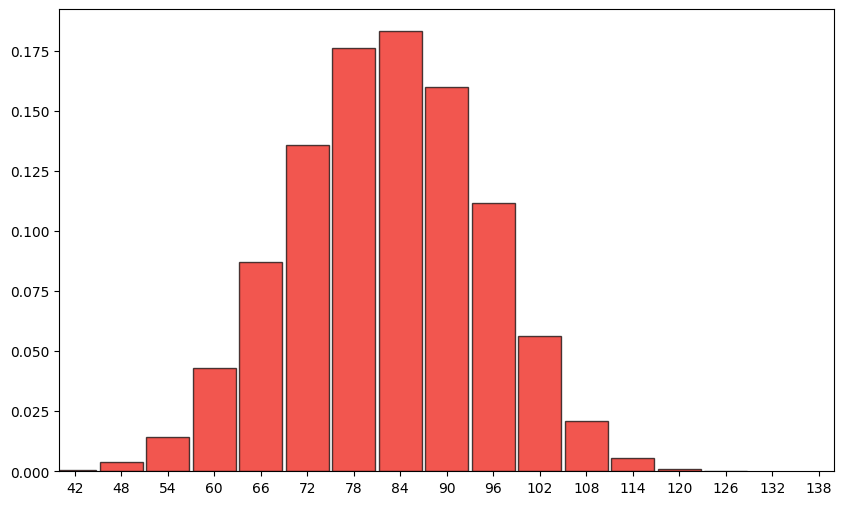

In [128]:
# Convert to numpy array for convenience
scores_arr = np.array(home_scores)
team = match_score.loc[match_id]['Home_Team']

fig, ax  = plt.subplots(figsize=(10, 6))

# Define bucket edges in multiples of 6
max_score = scores_arr.max()
bins = np.arange(0, max_score + 6, 6)  # 0, 6, 12, ...

# Digitize scores into buckets
bucket_indices = np.digitize(scores_arr, bins) - 1

# Calculate probability for each bucket
bucket_counts = np.bincount(bucket_indices, minlength=len(bins))
bucket_probs = bucket_counts / len(scores_arr)

# Use lower bound of each bin as the label
bucket_labels = bins[:-1]

# Plot
ax.bar(bucket_labels, bucket_probs[:-1], width=5.5, edgecolor='black', alpha=0.7, color = team_colours[team]['primary'])

# More frequent ticks — every 3 points
ax.set_xticks(np.arange(0, 140, 6));

ax.set_xlim(40, 140)

(40.0, 140.0)

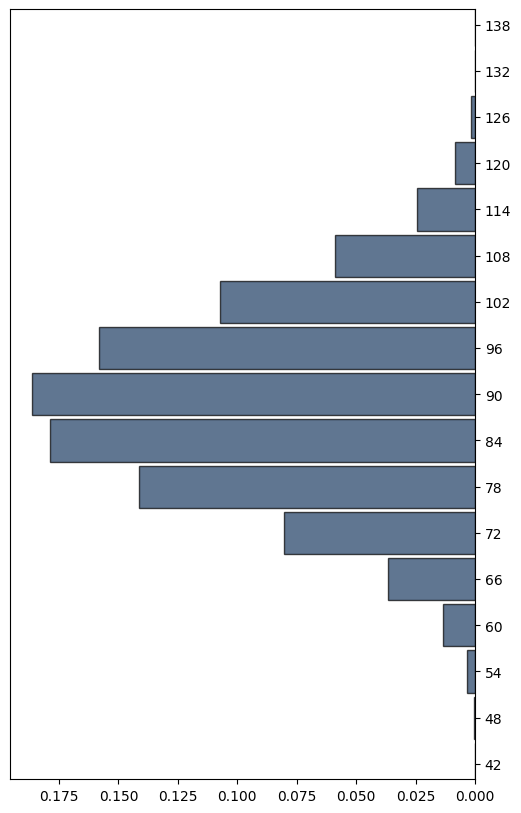

In [127]:
# Convert to numpy array for convenience
scores_arr = np.array(away_scores)
team = match_score.loc[match_id]['Away_Team']

fig, ax  = plt.subplots(figsize=(6, 10))

# Define bucket edges in multiples of 6
max_score = scores_arr.max()
bins = np.arange(0, max_score + 6, 6)  # 0, 6, 12, ...

# Digitize scores into buckets
bucket_indices = np.digitize(scores_arr, bins) - 1

# Calculate probability for each bucket
bucket_counts = np.bincount(bucket_indices, minlength=len(bins))
bucket_probs = bucket_counts / len(scores_arr)

# Use lower bound of each bin as the label
bucket_labels = bins[:-1]

# Plot
ax.barh(y=bucket_labels, width=bucket_probs[:-1], height=5.5, edgecolor='black', alpha=0.7, color = team_colours[team]['primary'])

# More frequent ticks — every 3 points
ax.set_yticks(np.arange(0, 140, 6));
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.invert_xaxis()

ax.set_ylim(40, 140)

In [295]:
from highlight_text import fig_text, ax_text

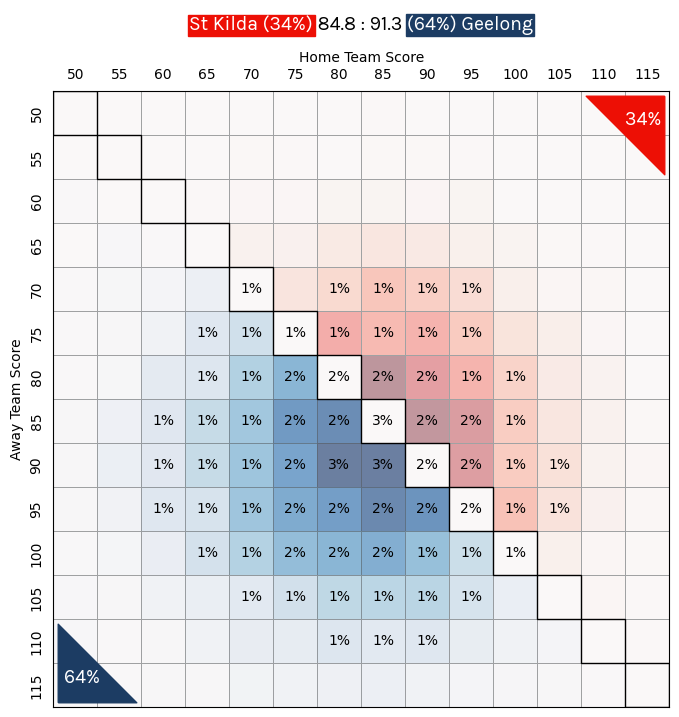

In [349]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from expected_score_model.visualisation.afl_colours import team_colourmaps

# Example data arrays (replace with your actual data)
home_scores_arr = np.array(home_scores)
away_scores_arr = np.array(away_scores)

# Define bins from 40 to 140 in steps of 6
bins = np.arange(50, 121, 5)  # 40, 46, 52, ..., 136, 142 (upper edge)
labels = bins[:-1]

# Filter scores to be within [40, 140]
valid_mask = (home_scores_arr >= 40) & (home_scores_arr <= 140) & \
             (away_scores_arr >= 40) & (away_scores_arr <= 140)

filtered_home = home_scores_arr[valid_mask]
filtered_away = away_scores_arr[valid_mask]

# Digitize filtered scores
home_buckets = np.digitize(filtered_home, bins) - 1
away_buckets = np.digitize(filtered_away, bins) - 1

# Initialize count matrix
heatmap_counts = np.zeros((len(bins), len(bins)))

# Count occurrences per bucket pair
for h, a in zip(home_buckets, away_buckets):
    heatmap_counts[a, h] += 1  # Note: swapped indices to put home on x-axis

# Convert to probability
heatmap_probs = heatmap_counts / len(filtered_home)


home_team = match_score.loc[match_id]['Home_Team']
away_team = match_score.loc[match_id]['Away_Team']

# Create masks
home_wins_mask = np.triu(np.ones_like(heatmap_probs), k=1)  # upper triangle (home team)
away_wins_mask = np.tril(np.ones_like(heatmap_probs), k=-1)  # lower triangle (away team)
draw_mask = np.eye(*heatmap_probs.shape)  # diagonal (draws)

# Extract masked probabilities
home_wins_probs = heatmap_probs * home_wins_mask
away_wins_probs = heatmap_probs * away_wins_mask
draw_probs = heatmap_probs * draw_mask

fig, ax = plt.subplots(figsize=(10, 8))

# Plot home wins (upper triangle) in Blues
sns.heatmap(
    home_wins_probs[:-1, :-1],
    xticklabels=labels,
    yticklabels=labels,
    cmap=team_colourmaps[home_team],
    cbar=False,
    square=True,
    linewidths=0.5,
    linecolor='gray',
    ax=ax
)

# Plot away wins (lower triangle) in Reds, with some transparency
sns.heatmap(
    away_wins_probs[:-1, :-1],
    xticklabels=labels,
    yticklabels=labels,
    cmap=team_colourmaps[away_team],
    cbar=False,
    square=True,
    linewidths=0.5,
    linecolor='gray',
    alpha=0.6,
    ax=ax
)

# Add annotations for all cells with > 0.1% probability
for i in range(len(labels)):
    for j in range(len(labels)):
        prob = heatmap_probs[i, j]
        prob = np.round(prob, 2)  # Round to 3 decimal places for display
        if prob > 0.001:
            ax.text(j + 0.5, i + 0.5, f"{prob:.0%}", ha='center', va='center', fontsize=10, color='black')

# Draw bold rectangles around diagonal cells
edge_width = 1
edge_color = 'black'

for i in range(len(labels)):
    rect = patches.Rectangle(
        (i, i), 1, 1,
        linewidth=edge_width,
        edgecolor=edge_color,
        facecolor='none',
        zorder=5
    )
    ax.add_patch(rect)


ax.tick_params(
    top=False, labeltop=True, 
    bottom=False, labelbottom=False,
    left=False, labelleft = True)

ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

ax.set_xlabel("Home Team Score")
ax.xaxis.set_label_position('top') 
ax.set_ylabel("Away Team Score")

upper_triangle_verts = [[1, 1], [1, -1], [-1, 1], [1, 1]]
ax.scatter(
    13, 1, 
    marker = upper_triangle_verts, 
    s=3200, 
    c=team_colours[home_team]['primary'], 
    zorder=10, )

annotation_text = f"{home_win_prob:.0%}"
ax.text(
    13., 14-13.35,
    annotation_text,
    ha='left', va='center',
    fontsize=14,
    color='white',  # a nice shade from colormap
    zorder=11,
    font = 'Karla'
)


lower_triangle_verts = [[-1, -1], [-1, 1], [1, -1], [-1, -1]]
ax.scatter(
    1, 13, 
    marker = lower_triangle_verts, 
    s=3200, 
    c=team_colours[away_team]['primary'],
    zorder=10, )

annotation_text = f"{away_win_prob:.0%}"
ax.text(
    0.25, 13.35,
    annotation_text,
    ha='left', va='center',
    fontsize=14,
    color='white',  # a nice shade from colormap
    zorder=11,
    font = 'Karla'
)

home_colour = team_colours[home_team]['primary']
away_colour = team_colours[away_team]['primary']

home_text_colour = 'black' if home_colour == 'white' else 'white'
away_text_colour = 'black' if home_colour == 'white' else 'white'

home_shots = shots[(shots['Match_ID'] == match_id) & (shots['Home'] == 'Home')]
away_shots = shots[(shots['Match_ID'] == match_id) & (shots['Home'] == 'Away')]

home_xscore = home_shots['xscore'].sum()
away_xscore = away_shots['xscore'].sum()

ax_text(
    7, -1.5, 
    f"<{home_team} ({home_win_prob:.0%})> {home_xscore:.1f} : {away_xscore:.1f} <({away_win_prob:.0%}) {away_team}>", 
    va='center',
    highlight_textprops=[
        # {'weight':'bold', 'font':'Karla'},
        {'size':'14', 'bbox':{'edgecolor':home_colour, 'facecolor':home_colour, 'pad':1}, 'color':home_text_colour},
        {'size':'14', 'bbox':{'edgecolor':away_colour, 'facecolor':away_colour, 'pad':1}, 'color':away_text_colour},
    ],
    font="Karla",
    ha="center",
    size=14)

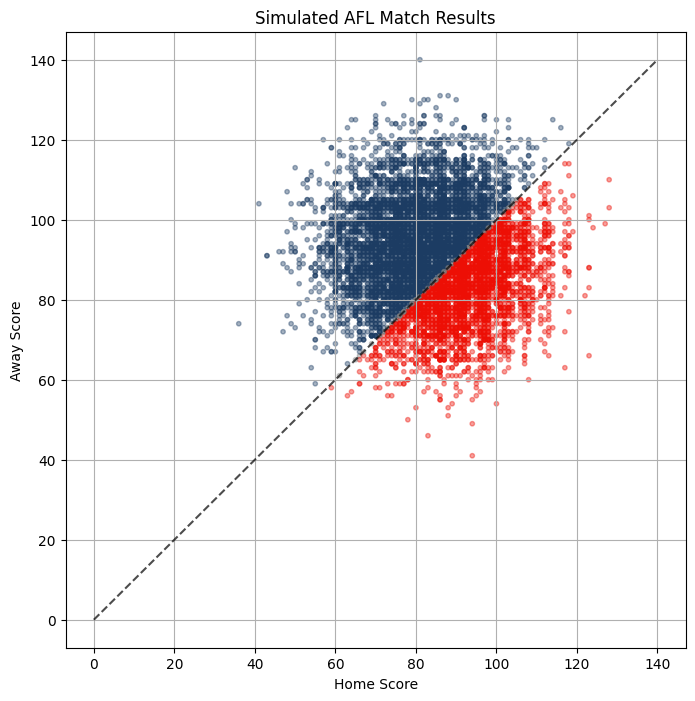

In [ ]:

# Classify results
results = np.array([
    "Home Win" if h > a else
    "Away Win" if a > h else
    "Draw"
    for h, a in zip(home_scores, away_scores)
])

home_team = match_score.loc[match_id]['Home_Team']
away_team = match_score.loc[match_id]['Away_Team']

# Map results to colors
color_map = {
    "Home Win": team_colours[home_team]['primary'],
    "Away Win": team_colours[away_team]['primary'],
    "Draw": "grey"
}
colors = [color_map[r] for r in results]

# Scatter plot of all scores
plt.figure(figsize=(8, 8))
plt.scatter(home_scores, away_scores, c=colors, alpha=0.4, s=10)

# Add line y = x for draw reference
plt.plot([0, max(home_scores + away_scores)], [0, max(home_scores + away_scores)], 'k--', alpha=0.7)

plt.xlabel("Home Score")
plt.ylabel("Away Score")
plt.title("Simulated AFL Match Results")
plt.grid(True)
plt.show()


In [ ]:
def expected_score_win_probability(match_id, n=10000):
    
    shots = 
    
    home_win_prob, away_win_prob, draw_prob = simulate_match_n_times(match_id, shots, n=10000)

    